# Introduction

This notebook exists for the exploration and analysis of canonical data collected by the [Ocean Observatories Initiative Regional Cabeled Array](https://interactiveoceans.washington.edu/). Creating a canonical record of seawater measurements is valuable in comparing data across platforms (RCA, ARGO, MODIS, GLODAP), locally and globally. The OOI RCA has multiple working stations off the Oregon coast that will be the focus of this notebook.

In order to explore data collected by the OOI RCA, we will utilize a python package called `yodapy` written by Don Setiawan at OOI. `yodapy` allows users to directly access information about the RCA and data collected by the RCA sensors. 


# Objectives

The objective of this notebook is to identify canonical values of seawater components across several years of available data at RCA sensor locations.

Overall, this includes evaluating the following:

* parameters of interest: temperature, salinity, dissolved oxygen, chlorophyll, possibly nitrate, possibly photosynthetically active radiation (par)
* depth intervals: 10 m intervals would be ideal
* time intervals: weekly averages and standard deviations would be ideal
* mean and standard deviation for each site, parameter, depth, and time
* sites:
    * 200m platforms and shallow  profilers (3 of these exist)
    * stretch goal: deep profilers (3 of these exist)

We'll begin by reducing the problem to 1 sensor, 1 parameter, 1 week, and 1 depth interval

* sensor: oregon slope base shallow profiler
* parameter: salinity
* week: aug 1-7, 2019
* 1 depth: first identify depth range available! 
* then find mean and stdev salinity for this location and time period

## Specific steps necessary to achieve the minimal objective

* choose a place to begin (see above)
* check the data availability via yodapy
    * (you can do steps 1 and 2 in opposite order if you specifically want a sensor that has good data availability)
* download data from this sensor
* open and read using netCDF4 function `Dataset('filename', 'r')`
* perform statistical analysis
* compare data over time

### A note about missing data
The RCA has limited resources and oceanic sensors are susceptible to connection issues, sensor breakages, and knock-downs that all contribute to anomalous data points or periods of missing data. For the sake of this project, time intervals that are missing a considerable amount of data (50% or more) will be marked as 'insufficient data'. 

* We need to agree on a work-around for anomalous data: how do we identify anomalies? how do we deal with them when we find them? We will cross this bridge when we get to it.

# If you've already run this notebook in it's entirety:

First, run the install and import cells below. Then, you can skip to about two thirds down in the notebook to the part titled "Skip to here if you have already run the notebook up to this point.". Running the notebook from that point onward assumes you've already requested and downloaded data from OOI and saved the following as pickle files in the output directory: binned data, means, standard deviations. Otherwise, start here.

In [ ]:
# install necessary packages

# Ensure that the latest build of yodapy is installed directly from github using
!pip install git+https://github.com/cormorack/yodapy.git -q     # -q cuts the stdout clutter
!pip install cmocean -q

In [5]:
# import necessary functions

import numpy as np
from numpy import datetime64 as dt64, timedelta64 as td64
import pickle

import sys, os
import shutil
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import cmocean.cm as cmo

from netCDF4 import Dataset, num2date, date2num 
from datetime import datetime, timedelta

from yodapy.datasources import OOI
ooi = OOI(cloud_source=True)

# Local application/library specific imports
#from golive_library import GoliveLibrary as g

from yodapy.utils.creds import set_credentials_file

In [3]:
# local imports
import my_module as mymod
from importlib import reload
reload(mymod)

<module 'my_module' from '/Users/derya/Documents/GitHub/coastal-upwelling/my_module.py'>

In [4]:
# make sure the output directory exists
this_dir = os.path.abspath('.').split('/')[-1]
this_parent = os.path.abspath('.').split('/')[-2]
out_dir = '../../' + this_parent + '/' + this_dir + '_output'
data_dir = '../../' + this_parent + '/' + this_dir + '_data/canon/'
print('Creating ' + out_dir + ', if needed')
mymod.make_dir(out_dir)
print('Creating ' + data_dir + ', if needed')
mymod.make_dir(data_dir)

Creating ../../GitHub/coastal-upwelling_output, if needed
Creating ../../GitHub/coastal-upwelling_data/canon/, if needed


## Setting up your OOI credentials

Visit [OOI website](https://ooinet.oceanobservatories.org/#) to get credentials. Be sure to obscure credentials before pushing this notebook to GitHub!

Sometimes the cell below will break on you! Restart the kernel and clear all output, and get a new token from OOI. Hopefully this fixes it.

Included in this section are multiple commented cells that are useful commands for familiarizing yourself with the structure and extent of the RCA. Uncomment the commands in the multiple following cells to see all of the sites and instruments available for evaluation.

If you ever get a message that says "Please wait while we fetch the metadata..." it might be necessary to rerun the cell that generated the message.

The cell below tells the OOI that you have an account with them through which you can submit data requests. This will allow you to download data for use in this notebook. If you don't already have an account, you can easily create one on the [OOI website](https://ooinet.oceanobservatories.org/#).

In [ ]:
# Remember to obscure your username and token when you're done!!!

set_credentials_file(data_source='ooi', username='OOIAPI-xxxx', token='TEMP-TOKEN-xxxx')

# Recomment this line after running it once! 
# Running it twice will break your credentials! 

In [6]:
# Run these to helpful see documentation on yodapy and ooi
# help(ooi)
# help(ooi.cava_sites)
ooi.cava_sites
# Run this to see all commands included in yodapy
# g.dirnou(ooi)

# Run this to see all sites included in the OOI RCA cava project (cava = cabled array value added)
# print(ooi.cava_sites, '\n\n\n', ooi.cava_parameters)

# Run this to see all the components or segments of OOI available
# ooi.sites

# Run this to see all the instruments of OOI available
# ooi.instruments

,reference_designator,site_name,site_url,site_area,wp_mapping,map_icon_mapping,in_progress_status
0,RS01SBPS,Oregon Slope Base Shallow Profiler,/research-sites/oregon-slope-base/,Oregon Slope Base,518,shallow-profiler,False
1,CE04OSPS,Oregon Offshore Shallow Profiler,/research-sites/oregon-offshore/,Oregon Offshore,518,shallow-profiler,False
2,RS03AXPS,Axial Base Shallow Profiler,/research-sites/axial-base/,Axial Base,518,shallow-profiler,False
3,CE02SHBP,Oregon Shelf Cabled Benthic Experiment Package,/research-sites/oregon-shelf/,Oregon Shelf,512,low-power-jbox,False
4,CE04OSBP,Oregon Offshore Cabled Benthic Experiment Package,/research-sites/oregon-offshore/,Oregon Offshore,512,low-power-jbox,False
5,RS01SLBS,Oregon Slope Base Seafloor,/research-sites/oregon-slope-base/,Oregon Slope Base,512,low-power-jbox,False
6,RS03ASHS,ASHES Vent Field,/research-sites/axial-caldera/ashes/,Axial Caldera,512,medium-power-jbox,False
7,RS03AXBS,Axial Base Seafloor,/research-sites/axial-base/,Axial Base,512,low-power-jbox,False
8,RS01SBPD,Oregon Slope Base Deep Profiler,/research-sites/oregon-slope-base/,Oregon Slope Base,516,deep-profiler,True
9,RS01SUM1,Southern Hydrate Summit 2 Seafloor,/research-sites/southern-hydrate-ridge/,Southern Hydrate Ridge,429,low-power-jbox,True


### Exploring the OOI cabled arrays


If you run any of the commands in the code cell above, you'll see that there are quite a lot of components to the RCA. With over 60 sites and 5000+ instruments, it can be difficult to identify the exact data we want. Fortunately, we are familiar with the RCA structure and terminology. Remember that you can visit the [Interactive Oceans Data Portal](https://app.interactiveoceans.washington.edu/) to learn about the site locations, instruments, parameters, and data availability for the entire RCA system. The data portal is also where to go **if you don't know the names of sites, nodes, or instruments that you're interested in, or if you want to see data availability on a day-by-day basis.**

In [89]:
# Narrow the search using the appropriate terms.

ooi.search(region='cabled', site='oregon slope base', node='shallow', instrument='CTD')

<Data Source: OOI (0 Instrument Stream)>

The cell below is broken

In [37]:
# Check the data availability of the selected instrument. Long periods of data may be missing.

#ooi.data_availability()    # try running this cell twice if a green time plot doesn't appear on the first run

From the Interactive Oceans Data Portal we can see data availability for the CTD on the Oregon Slope Base Shallow Profiler (note that this instrument is referred to as a 'CTD-O' on the data portal because it also has an **O**xygen sensor). Below is a screenshot of the day-by-day availability of the same instrument. A more interactive version can be found on the Data Portal.

<img src="./OreSlope_ShallProf_CTD_DataAvailability.PNG">

## Requesting and downloading data

With the desired instrument(s) selected, generate a data request to the OOI system using the code below. This data only needs to be downloaded **once.** It will benefit you to rename the downloaded file(s) to something more meaningful, such as 'site_node_instrument_####.nc' where #### = 0001, 0002, 0003 . . . 9999. For your convenience, one of the cells below takes the initiative and moves the file to the data directory (../../GitHub/eScience-Work_data/canon/) and renames it using the naming convention 'site_node_instrument_YYYY-MM-DD_MM-DD.nc' where 'MM-DD_MM-DD' describes the date range of the dataset. 

You only need to run the request and download commands (below) **once.** If you have already done this or just want to skip ahead, you can skip to the section about two thirds of the way through this notebook titled **"Skip to here if you have already run the notebook up to this point."**

In [27]:
'''Running .request_data() generates a data request
while running .to_xarray() polls the OOI system until the order completes; 
 this will take a couple of minutes'''


# Enter desired start and end dates and generate data request
begin_date = '2019-08-01'
end_date = '2019-08-08'    # the data file will include measurements close as possible to midnight on the morning of 2019-08-08 


# editing these
%time req_asseet = ooi.request_data(begin_date=begin_date, end_date=end_date)
filenamelist = ooi.to_xarray()


# Check length of new dataset list to ensure the correct number of files was requested
len(ds)

CPU times: user 46.7 s, sys: 2.4 s, total: 49.1 s
Wall time: 2min 19s


2

The cell below is broken, replacing it with technique from cava_cloud_example.ipynb

In [36]:
# Run this to download the data (possibly multiple files) from a completed data request from above
# 
#filenamelist = ooi.download_netcdfs()
filenamelist

# Rerunning this cell will result in `TypeError: object of type 'NoneType' has no len()`. 
# Rerunning an `ooi.request_data()` command after rerunning this cell will result in 
# `AttributeError: 'NoneType' object has no attribute 'copy'`.

[<xarray.Dataset>
 Dimensions:                                 (time: 598189)
 Coordinates:
   * time                                    (time) datetime64[ns] 2019-08-01T...
     lat                                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
     lon                                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
     seawater_pressure                       (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
 Data variables: (12/29)
     conductivity                            (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
     corrected_dissolved_oxygen              (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
     corrected_dissolved_oxygen_qc_executed  (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
     corrected_dissolved_oxygen_qc_results   (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
     density                                 

Exception in thread process-request:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/yodapy/datasources/ooi/OOI.py", line 1143, in _threader
    self._q.task_done()
  File "/opt/anaconda3/lib/python3.8/queue.py", line 74, in task_done
    raise ValueError('task_done() called too many times')
ValueError: task_done() called too many times


In [29]:
data_dir = './data/'

In [30]:
# Move the file to the data directory and rename it with an informative file name.

try:
    oldname = filenamelist[0]
    newname = data_dir + 'OreSlope_ShallProf_CTD_2019-08-01_08-08.nc'
    shutil.move(oldname, newname)
except: 
    pass

pick up here

In [38]:
ds = filenamelist[0]

In [39]:
ds

<xarray.Dataset>
Dimensions:                                 (time: 598189)
Coordinates:
  * time                                    (time) datetime64[ns] 2019-08-01T...
    lat                                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    lon                                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_pressure                       (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
Data variables: (12/29)
    conductivity                            (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    corrected_dissolved_oxygen              (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_executed  (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_results   (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    density                                 (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    density_qc_executed                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    ...                                      ...
    seawater_pressure_qc_executed           (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_pressure_qc_results            (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_temperature                    (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_temperature_qc_executed        (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_temperature_qc_results         (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    temperature                             (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>

### Preparing the data for analysis

Now we can open the downloaded dataset and look at the contents. Remember that we are focusing on one dataset (Oregon Slope Base shallow profiler CTD, first week of August 2019) and one parameter (salinity) to start with. Looking through all the variables, you can find multiple entries for salinity, including: 'conductivity', 'seawater_conductivity', 'practical_salinity', 'seawater_conductivity_qc_executed', 'seawater_conductivity_qc_results' 'practical_salinity_qc_executed', and 'practical_salinity_qc_results'. 

Documentation for the netCDF4 functions used can be found [here.](https://unidata.github.io/netcdf4-python/netCDF4/index.html#netCDF4.Dataset)

By opening the dataset as an xarray dataset and not the netCDF object it exists as, we can far more easily manipulate the data and explore data across different sets. Utilizing the "swap_dims" function in xarray, we can ensure that all variables are associated with the 'time' coordinate.  That is to say, when we call the 'pressure' variable, it will automatically be associated with the 'time' coordinate and can be easily plotted along that axis.

In [48]:
ds_2019 = ds

In [40]:
# Open dataset in read mode

#ds = xr.open_dataset(data_dir + 'OreSlope_ShallProf_CTD_2019-08-01_08-08.nc')     #Open file as xarray dataset
#ds_2019 = ds.swap_dims({'obs':'time'})    #Swap default 'obs' dimension for 'time'
depth = 'seawater_pressure'

The CTD lists 3 variable for conductivity/salinity.  By printing the listing for these variables, we can see that the "practical_salinity" variable most closely matches what we want to explore.

In [49]:
# print(ds.variables['conductivity'])
# print('\n')

# print(ds.variables['seawater_conductivity'])
# print('\n')

print(ds_2019.variables['practical_salinity'])
print('\n')
print(type(ds_2019))

<xarray.Variable (time: 598189)>
dask.array<getitem, shape=(598189,), dtype=float64, chunksize=(96398,), chunktype=numpy.ndarray>
Attributes:
    ancillary_variables:      pressure conductivity temperature
    comment:                  Salinity is generally defined as the concentrat...
    data_product_identifier:  PRACSAL_L2
    long_name:                Practical Salinity
    precision:                4
    standard_name:            sea_water_practical_salinity
    units:                    1


<class 'xarray.core.dataset.Dataset'>


### Data visualization

Now we can take a look at the raw data by plotting the practical salininty vs. seawater pressure. Below that, we can also create a time series plot of this data. The time series plot shows the 9 daily trips up and down the water column that the shallow profiler makes, reflected in changes in the salinity. 

Text(0, 0.5, 'Seawater pressure (dbar)')

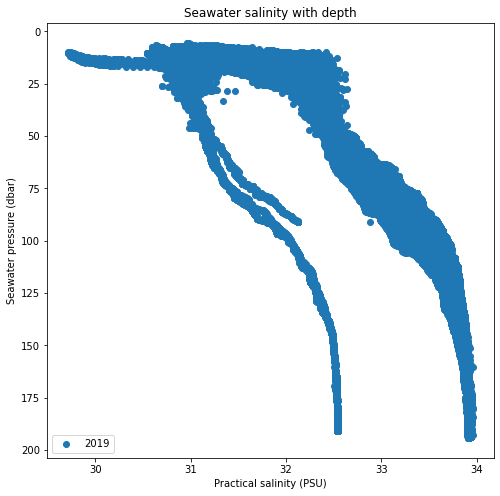

In [50]:
# initialize a figure object
fig = plt.figure(figsize=(8,8))

# initialize an axis object
ax =  fig.add_subplot(111)

# plot salinity vs pressure
ax.scatter(ds_2019.practical_salinity, ds_2019.seawater_pressure, label=2019)
ax.invert_yaxis()    # this is the alternative to: plt.gca().invert_yaxis()
ax.legend(loc='lower left')
ax.set_title('Seawater salinity with depth')
ax.set_xlabel('Practical salinity (PSU)')
ax.set_ylabel('Seawater pressure (dbar)')

<ipython-input-51-33ef8cd136c6>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Aug 1', 'Aug 2', 'Aug 3', 'Aug 4', 'Aug 5', 'Aug 6', 'Aug 7'])


Text(0, 0.5, 'Pracitcal salinity (PSU)')

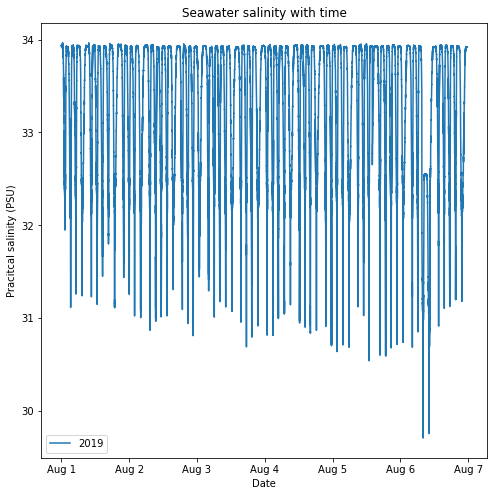

In [51]:
# initialize a figure object
fig = plt.figure(figsize=(8,8))

# initialize an axis object
ax =  fig.add_subplot(111)

# plot salinity vs time
ax.plot(ds_2019.practical_salinity, label=2019)
ax.legend(loc='lower left')
ax.set_title('Seawater salinity with time')
ax.set_xticklabels(['', 'Aug 1', 'Aug 2', 'Aug 3', 'Aug 4', 'Aug 5', 'Aug 6', 'Aug 7'])
ax.set_xlabel('Date')
ax.set_ylabel('Pracitcal salinity (PSU)')

### Binning data to get mean and standard deviation

The last steps in preparing our data for analysis is to bin it according to our desired depth intervals for just the parameter we are interested in (practical salinity). Separating the practical salinity from the rest of the data speeds up our calculations considerably. 

Once we have the data for our parameter grouped into bins of 10m depth intervals, we can use built-in functions to calculate the mean and standard deviation for practical salinity. The `.mean()` and `.std()` functions may take a minute to run. 

In [52]:
# binning data

depth = 'seawater_pressure'
bin_list = list(np.arange(0,250,10))

# bin 2019 data
ds = ds_2019.practical_salinity
sal_2019_bin = ds.groupby_bins(group = depth, bins = bin_list)

# calculate stats
sal_2019_mean = sal_2019_bin.mean()
sal_2019_stdev = sal_2019_bin.std()

(MainThread) NumExpr defaulting to 8 threads.


### Comparing August 2019 to August 2018, 2017, and so on

Now that we have established a mean and standard deviation for the first week of August 2019, let's do the same thing for the first week of August of previous years. Then we can begin to see what canonical values of practical salinity are for this time of year at this location. The cells below are a streamlined version of the steps that replicates the steps done above. 

For now, let's just pull in data for the first week of August of 2018. First we'll request and download the data. Again, the data file will be renamed and move to the data directory. Then we'll open the dataset, swap the dimensions, isolate the practical salinity data, bin this data into 10 meter intervals, and calculate the mean and standard deviation for these intervals. 

In [73]:
'''Running .request_data() generates a data request
while running .to_xarray() polls the OOI system until the order completes; 
 this will take a couple of minutes'''


# Enter desired start and end dates and generate data request
begin_date = '2018-08-01'
end_date = '2018-08-08'    # the data file will include measurements close as possible to midnight on the morning of 2019-08-08 
req_asset = ooi.request_data(begin_date=begin_date, end_date=end_date)
ds_list = ooi.to_xarray()


# Check length of new dataset list to ensure the correct number of files was requested
ds = ds_list[0]

# Run this to download the data (possibly multiple files) from a completed data request from above

# filenamelist = ooi.download_netcdfs()
# len(filenamelist)

# Move the file to the data directory and rename it with an informative file name.

# try:
#     oldname = filenamelist[0]
#     newname = data_dir + 'OreSlope_ShallProf_CTD_2018-08-01_08-08.nc'
#     shutil.move(oldname, newname)
# except: 
#     pass

In [76]:
ds_list[0]

<xarray.Dataset>
Dimensions:                                 (time: 598189)
Coordinates:
  * time                                    (time) datetime64[ns] 2019-08-01T...
    lat                                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    lon                                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_pressure                       (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
Data variables: (12/29)
    conductivity                            (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    corrected_dissolved_oxygen              (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_executed  (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_results   (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    density                                 (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    density_qc_executed                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    ...                                      ...
    seawater_pressure_qc_executed           (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_pressure_qc_results            (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_temperature                    (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_temperature_qc_executed        (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_temperature_qc_results         (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    temperature                             (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>

In [77]:
ds_2018 = ds_list[-1]

In [74]:
for ds in ds_list:
    print(ds.head())

<xarray.Dataset>
Dimensions:                                 (time: 5)
Coordinates:
  * time                                    (time) datetime64[ns] 2019-08-01T...
    lat                                     (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    lon                                     (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    seawater_pressure                       (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
Data variables: (12/29)
    conductivity                            (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    corrected_dissolved_oxygen              (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_executed  (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_results   (time) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    density                                 (time) float64 dask.array<chunksize=(5,), meta

In [56]:
ds = ds_list[0]

In [78]:
# Open dataset in read mode

#ds = xr.open_dataset(data_dir + 'OreSlope_ShallProf_CTD_2018-08-01_08-08.nc')     #Open file as xarray dataset
#ds_2018 = ds.swap_dims({'obs':'time'})    #Swap default 'obs' dimension for 'time'
# ds_2018 = ds
# bin data
ds = ds_2018.practical_salinity
sal_2018_bin = ds.groupby_bins(group = depth, bins = bin_list)

# calculate stats
sal_2018_mean = sal_2018_bin.mean()
sal_2018_stdev = sal_2018_bin.std()

### Pickle files

It can be useful to save calculations as an output called a "pickle file". These files can then be stored and read elsewhere so that users don't have to repeatedly run time-consuming functions. In this case, let's save the binned data, the means, and the standard deviations for the salinity data from 2018 and 2019 in the cell below. This gives us a great "save" point to pick up from when we rerun the notebook in the future. No need to redownload data and redo calculations for the same dataset every time we run this code. 

In [58]:
out_dir

'../../GitHub/coastal-upwelling_output'

In [59]:
# save binned data and statistics as pickle files to save time on future runthroughs.

# write pickle files (first time running notebook)
out_fn = out_dir + '/sal_2019_bin.p'
pickle.dump(sal_2019_bin, open(out_fn, 'wb')) # 'wb' is for write binary

out_fn = out_dir + '/sal_2019_mean.p'
pickle.dump(sal_2019_mean, open(out_fn, 'wb'))

out_fn = out_dir + '/sal_2019_stdev.p'
pickle.dump(sal_2019_stdev, open(out_fn, 'wb'))

# save it as a pickle file
out_fn = out_dir + '/sal_2018_bin.p'
pickle.dump(sal_2018_bin, open(out_fn, 'wb')) # 'wb' is for write binary

out_fn = out_dir + '/sal_2018_mean.p'
pickle.dump(sal_2018_mean, open(out_fn, 'wb')) # 'wb' is for write binary

out_fn = out_dir + '/sal_2018_stdev.p'
pickle.dump(sal_2018_stdev, open(out_fn, 'wb')) # 'wb' is for write binary

# Skip to here if you have already run the notebook up to this point.

### The cell below reads in existing pickle files, you can skip it if you've run all the cells up to this point.

As stated above, it is time-consuming and redundant to repeatedly download and perform calculations on the same datasets every time we want to run this notebook. One way to speed past this is to save the outputs of these calculations as pickle files (this is done in the cell above) and load them in for plotting and interpretation (this is done in the cell below). Then when you want to rerun the notebook, you can skip straight to this point if those pickle files are located in your output directory (../../GitHub/eScience-Work_output). 

In [79]:
# parameters are redefined and datasets are reopened in case users skip directly to this point as instructed.

depth = 'seawater_pressure'
bin_list = list(np.arange(0,250,10))

# Open dataset in read mode

# ds = xr.open_dataset(data_dir + 'OreSlope_ShallProf_CTD_2019-08-01_08-08.nc')     #Open file as xarray dataset
# ds_2019 = ds.swap_dims({'obs':'time'})    #Swap default 'obs' dimension for 'time'
# depth = 'seawater_pressure'

# ds = xr.open_dataset(data_dir + 'OreSlope_ShallProf_CTD_2018-08-01_08-08.nc')     #Open file as xarray dataset
# ds_2018 = ds.swap_dims({'obs':'time'})    #Swap default 'obs' dimension for 'time'
# depth = 'seawater_pressure'

# read in pickle arrays for plotting
file_list = ['sal_2019_mean.p', 'sal_2019_stdev.p', 'sal_2018_mean.p', 'sal_2018_stdev.p']
data_list = []

# loop through files and open each of them
for item in file_list:
    out_fn = out_dir + '/' + item
    data = pickle.load(open(out_fn, 'rb')) # 'rb is for read binary
    data_list.append(data)

# name files accordingly
sal_2019_mean = data_list[0]
sal_2019_stdev = data_list[1]
sal_2018_mean = data_list[2]
sal_2018_stdev = data_list[3]

In [80]:
ds_2018

<xarray.Dataset>
Dimensions:                                 (time: 604782)
Coordinates:
  * time                                    (time) datetime64[ns] 2018-08-01T...
    lat                                     (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    lon                                     (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    seawater_pressure                       (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
Data variables: (12/29)
    conductivity                            (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    corrected_dissolved_oxygen              (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_executed  (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_results   (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    density                                 (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    density_qc_executed                     (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    ...                                      ...
    seawater_pressure_qc_executed           (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    seawater_pressure_qc_results            (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    seawater_temperature                    (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    seawater_temperature_qc_executed        (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    seawater_temperature_qc_results         (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>
    temperature                             (time) float64 dask.array<chunksize=(96397,), meta=np.ndarray>

In [81]:
ds_2019

<xarray.Dataset>
Dimensions:                                 (time: 598189)
Coordinates:
  * time                                    (time) datetime64[ns] 2019-08-01T...
    lat                                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    lon                                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_pressure                       (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
Data variables: (12/29)
    conductivity                            (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    corrected_dissolved_oxygen              (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_executed  (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    corrected_dissolved_oxygen_qc_results   (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    density                                 (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    density_qc_executed                     (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    ...                                      ...
    seawater_pressure_qc_executed           (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_pressure_qc_results            (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_temperature                    (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_temperature_qc_executed        (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    seawater_temperature_qc_results         (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>
    temperature                             (time) float64 dask.array<chunksize=(96398,), meta=np.ndarray>

<ipython-input-82-ba7063b97741>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Aug 1', 'Aug 2', 'Aug 3', 'Aug 4', 'Aug 5', 'Aug 6', 'Aug 7'])


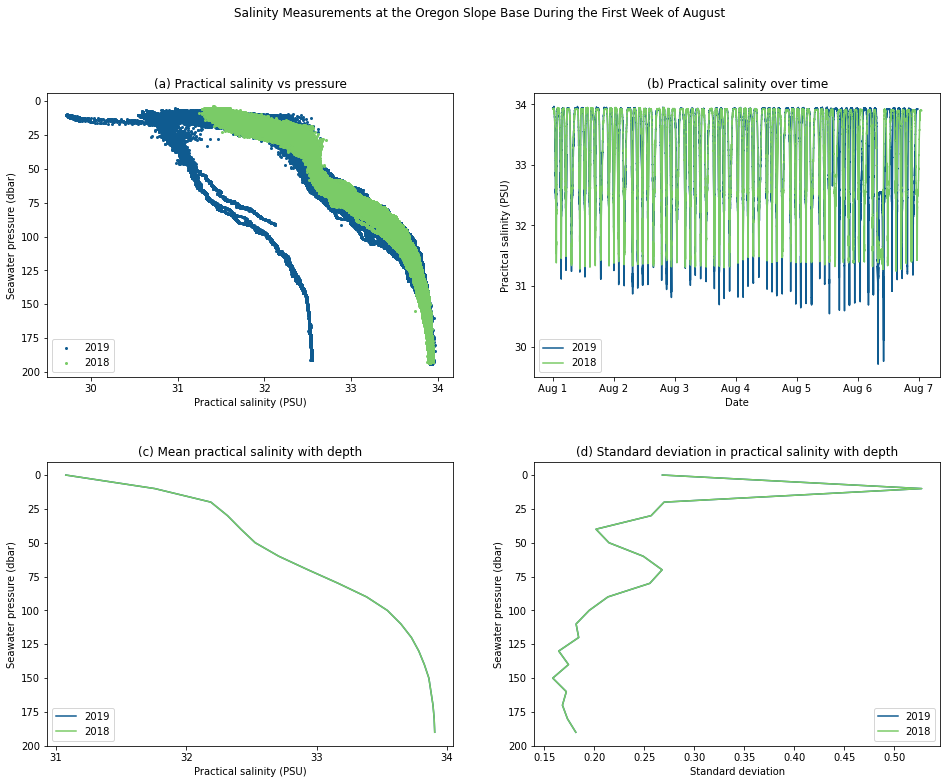

In [82]:
# Make a nice plot

# create a figure object with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12), squeeze=False)
fig.suptitle('Salinity Measurements at the Oregon Slope Base During the First Week of August')
plt.rc('lines', markersize=2)    # small markers for the scatter plot looks best
plt.subplots_adjust(hspace=0.3)    # horizontal space between plots to prevent label overlap

# get 2 colors from the haline colormap
c1 = cmo.haline(0.25)
c2 = cmo.haline(0.75)

#ds_2019.plot.pcolormesh('time', 'seawater_pressure') # could this work?

# first plot: salinity vs depth
ax = axes[0,0]
ax.scatter(ds_2019.practical_salinity, ds_2019.seawater_pressure, color=c1, label='2019')
ax.scatter(ds_2018.practical_salinity, ds_2018.seawater_pressure, color=c2, label='2018')
ax.invert_yaxis()    # this is the alternate to: plt.gca().invert_yaxis()
ax.legend(loc='lower left')
ax.set_title('(a) Practical salinity vs pressure')
ax.set_xlabel('Practical salinity (PSU)')
ax.set_ylabel('Seawater pressure (dbar)')

# second plot: salinity vs time
ax = axes[0,1]
ax.plot(ds_2019.practical_salinity, c=c1, label='2019')
ax.plot(ds_2018.practical_salinity, c=c2, label='2018')
ax.legend(loc='lower left')
ax.set_title('(b) Practical salinity over time')
ax.set_xticklabels(['', 'Aug 1', 'Aug 2', 'Aug 3', 'Aug 4', 'Aug 5', 'Aug 6', 'Aug 7'])
ax.set_xlabel('Date')
ax.set_ylabel('Pracitcal salinity (PSU)')
#ax.invert_yaxis()    # does it make sense to invert this axis?

# third plot: mean salinity over binned depth
ax = axes[1,0]
ax.plot(sal_2019_mean, bin_list[:-1], c=c1, label='2019')
ax.plot(sal_2018_mean, bin_list[:-1], c=c2, label='2018')
ax.legend(loc='lower left')
ax.invert_yaxis()
ax.set_title('(c) Mean practical salinity with depth')
ax.set_xticks([31,32,33,34])
ax.set_xlabel('Practical salinity (PSU)')
ax.set_yticks([0,25,50,75,100,125,150,175,200])
ax.set_ylabel('Seawater pressure (dbar)')

# fourth and final plot: standard deviation in salinity over binned depth
ax = axes[1,1]
ax.plot(sal_2019_stdev, bin_list[:-1], c=c1, label='2019')
ax.plot(sal_2018_stdev, bin_list[:-1], c=c2, label='2018')
ax.legend(loc='lower right')
ax.invert_yaxis()
ax.set_title('(d) Standard deviation in practical salinity with depth')
ax.set_xlabel('Standard deviation')
ax.set_yticks([0,25,50,75,100,125,150,175,200])
ax.set_ylabel('Seawater pressure (dbar)')

# Save the figure to output directory
plt.savefig(out_dir + '/sal_summary_plot.png')

# Interpretations

This is really interesting! In the (a) panel we can see a strong generalized curve of salinity with depth. The 2019 data appears to have a large clump of fresher measurements near the surface, as well as 1-2 profiles that exhibit the same curve but about 1.5 PSU fresher than the rest of the data. Why is this? Most likely, the sensor bugged out for some  currently unknown reason. It's possible that this date (looks to be Aug 6 2019) coincided with a Visions cruise and the atypical data was measured as the shallow profiler was being serviced. Panel (b) shows us that yes, this week of 2019 was generally fresher than the same week of 2018. Panel (c) shows us that the means of data (binned in 10-meter depth intervals) from 2018 and 2019 are very similar; again, 2019 recorded fresher measurements. Panel (d) shows us that 2019 had considerably higher standard deviation than 2018 for the entire 200 meters. Disregard that for a moment and consider the shapes of these curves. Notice first the large spike between 0 and 25 meters, then the decrease between 25 and 50 meters, and the second, smaller spike around 75 meters. Why does the standard deviation change with depth in this manner? One possibility is that these spikes in standard deviation are occuring at the borders between two bodies of water that possess significantly different salinities. The depths with low standard deviation would then likely be layers of water the possess a relatively stable salinity over depth. We might expect to see similar standard deviation curves in seawater temperature data at the same times and location, so let's see if we can replicate this. 

### Adding temperature data 

The following code applies the steps we took to look at salinity data and applies them to temperature data from the same 2019 and 2018 datasets. This includes binning seawater temperature data and calculating the means and standard deviations for both years. These calculations are saved as pickle files so that this does not need to be repeated. 

In [83]:
# SKIP this cell if you've already run the notebook in it's entirey

# bin 2019 temperature data
ds = ds_2019.seawater_temperature
temp_2019_bin = ds.groupby_bins(group = depth, bins = bin_list)

# calculate stats
temp_2019_mean = temp_2019_bin.mean()
temp_2019_stdev = temp_2019_bin.std()

# bin 2018 temperature data
ds = ds_2018.seawater_temperature
temp_2018_bin = ds.groupby_bins(group = depth, bins = bin_list)

# calculate stats
temp_2018_mean = temp_2018_bin.mean()
temp_2018_stdev = temp_2018_bin.std()

# save binned data and statistics as pickle files

# write pickle files (first time running notebook)
out_fn = out_dir + '/temp_2019_bin.p'
pickle.dump(temp_2019_bin, open(out_fn, 'wb')) # 'wb' is for write binary

out_fn = out_dir + '/temp_2019_mean.p'
pickle.dump(temp_2019_mean, open(out_fn, 'wb'))

out_fn = out_dir + '/temp_2019_stdev.p'
pickle.dump(temp_2019_stdev, open(out_fn, 'wb'))

# save it as a pickle file
out_fn = out_dir + '/temp_2018_bin.p'
pickle.dump(temp_2018_bin, open(out_fn, 'wb')) # 'wb' is for write binary

out_fn = out_dir + '/temp_2018_mean.p'
pickle.dump(temp_2018_mean, open(out_fn, 'wb')) # 'wb' is for write binary

out_fn = out_dir + '/temp_2018_stdev.p'
pickle.dump(temp_2018_stdev, open(out_fn, 'wb')) # 'wb' is for write binary

In [84]:
# SKIP this cell if you ran the cell directly above

# read in pickle arrays for plotting
file_list = ['temp_2019_mean.p', 'temp_2019_stdev.p', 'temp_2018_mean.p', 'temp_2018_stdev.p']
data_list = []

# loop through files and open each of them
for item in file_list:
    out_fn = out_dir + '/' + item
    data = pickle.load(open(out_fn, 'rb')) # 'rb is for read binary
    data_list.append(data)

# name files accordingly
temp_2019_mean = data_list[0]
temp_2019_stdev = data_list[1]
temp_2018_mean = data_list[2]
temp_2018_stdev = data_list[3]

<ipython-input-85-4229e3d4a593>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Aug 1', 'Aug 2', 'Aug 3', 'Aug 4', 'Aug 5', 'Aug 6', 'Aug 7'])


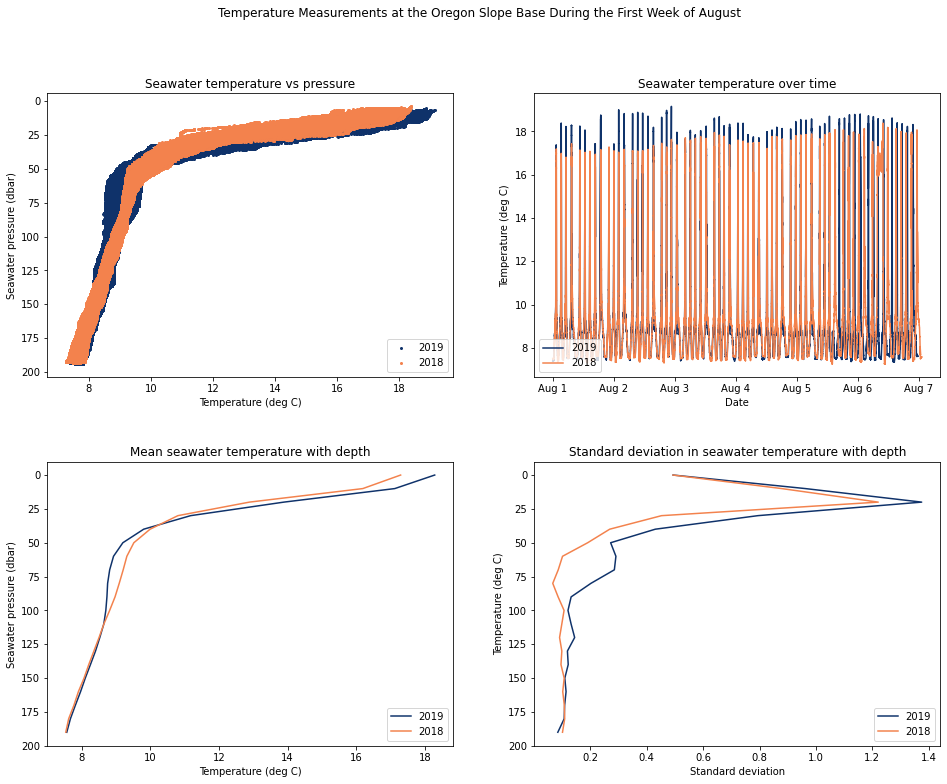

In [85]:
# Make another nice plot

# create fig with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12), squeeze=False)
fig.suptitle('Temperature Measurements at the Oregon Slope Base During the First Week of August')
plt.rc('lines', markersize=2)    # small markers for the scatter plot looks best
plt.subplots_adjust(hspace=0.3)    # horizontal space between plots to prevent label overlap

# get 2 colors from the thermal colormap
c1 = cmo.thermal(0.1)
c2 = cmo.thermal(0.7)

# first plot: seawater temperature vs depth
ax = axes[0,0]
ax.scatter(ds_2019.seawater_temperature, ds_2019.seawater_pressure, color=c1, label=2019)
ax.scatter(ds_2018.seawater_temperature, ds_2018.seawater_pressure, color=c2, label=2018)
ax.invert_yaxis()    # this is the alternate to: plt.gca().invert_yaxis()
ax.legend(loc='lower right')
ax.set_title('Seawater temperature vs pressure')
ax.set_xlabel('Temperature (deg C)')
ax.set_ylabel('Seawater pressure (dbar)')

# second plot: seawater temperature vs time
ax = axes[0,1]
ax.plot(ds_2019.seawater_temperature, c=c1, label=2019)
ax.plot(ds_2018.seawater_temperature, c=c2, label=2018)
ax.legend(loc='lower left')
ax.set_title('Seawater temperature over time')
ax.set_xticklabels(['', 'Aug 1', 'Aug 2', 'Aug 3', 'Aug 4', 'Aug 5', 'Aug 6', 'Aug 7'])
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (deg C)')
#ax.invert_yaxis()    # does it make sense to invert this axis?

# third plot: mean seawater temperature over binned depth
ax = axes[1,0]
ax.plot(temp_2019_mean, bin_list[:-1], c=c1, label=2019)
ax.plot(temp_2018_mean, bin_list[:-1], c=c2, label=2018)
ax.legend(loc='lower right')
ax.invert_yaxis()
ax.set_title('Mean seawater temperature with depth')
#ax.set_xticks([31,32,33,34])
ax.set_xlabel('Temperature (deg C)')
ax.set_yticks([0,25,50,75,100,125,150,175,200])
ax.set_ylabel('Seawater pressure (dbar)')

# fourth plot: standard deviation in seawater temperature over binned depth
ax = axes[1,1]
ax.plot(temp_2019_stdev, bin_list[:-1], c=c1, label=2019)
ax.plot(temp_2018_stdev, bin_list[:-1], c=c2, label=2018)
ax.legend(loc='lower right')
ax.invert_yaxis()
ax.set_title('Standard deviation in seawater temperature with depth')
ax.set_xlabel('Standard deviation')
ax.set_yticks([0,25,50,75,100,125,150,175,200])
ax.set_ylabel('Temperature (deg C)')

# Save the figure to output directory
plt.savefig(out_dir + '/temp_summary_plot.png')

# Avenues for future work

This work is truly the tip of the iceberg for analyzing data data from the OOI RCA. The code written here could be applied to similar netCDF datasets and could be expanded to explore even more of the numerous datasets obtained by the OOI RCA instruments.

Combine the many steps of this workflow (download data, bin data, calculate mean & stdev, plot) into a single function instead of copy/pasting the same code multiple times. This will make it easier and more efficient to explore more datasets. 

Most importantly, expand the scope of this notebook to look at the entirety of the RCA timeline, locations, and parameters. This would  include a **lot** of data and would give enormous insight into how reliable RCA data is over time, as well as giving us a representative view of seawater characteristics at RCA sites during any given time of year.